In [54]:
from scipy.stats import beta
from scipy.special import betaln
import scipy.stats
import numpy 
import pandas as pd
import scipy.stats as scs

In [3]:
users_A= 8145
conversions_A= 856
users_B = 8168
conversions_B= 936

### Modelo Bayesiano

In [7]:

def prob_B_beats_A(alpha_A, beta_A, alpha_B, beta_B):
    total = 0
    for i in range(0,alpha_B-1):
        total += np.exp(betaln(alpha_A + i, beta_B + beta_A) - \
            np.log(beta_B + i) - betaln(1+i, beta_B) - betaln(alpha_A, beta_A))
    return total
  
alpha_A = 1 + (conversions_A)
beta_A = 1 + (users_A - conversions_A)
alpha_B = 1 + (conversions_B)
beta_B = 1 + (users_B - conversions_B)
  
p_test_is_winner = prob_B_beats_A(alpha_A, beta_A, alpha_B, beta_B)
print("Probability that B beats A is: {:2.2f}%".format(100*p_test_is_winner))

Probability that B beats A is: 97.24%


### Chi quadrado , student t test

In [24]:
a_conversions= 856
a_no_conversions= 8145- a_conversions

b_conversions= 936
b_no_conversions= 8145- a_conversions


In [25]:
data= numpy.array([[a_no_conversions,a_conversions],[b_no_conversions,b_conversions ]])

chi_square, p_value = scipy.stats.chi2_contingency(data)[:2]

print('X2: %.4f' % chi_square)

print('p-value: %.4f' % p_value)

X2: 2.8751
p-value: 0.0900


--------------


In [42]:
df= pd.DataFrame()
group= ['A', 'B']
converted= [856,936]
total= [8145,8168]
rate=[0.105,0.115]


TypeError: 'type' object is not subscriptable

In [51]:
df['group']=group
df['converted']=converted
df['total']=total
df['rate']= rate
df.set_index('group')

,converted,total,rate
group,,,
A,856,8145,0.105
B,936,8168,0.115


In [52]:
# get values for all the variables
B_converted= 936
A_converted =856
B_total = 8168
A_total = 8145
A_cr = 0.105
B_cr = 0.115

Text(0, 0.5, 'probability')

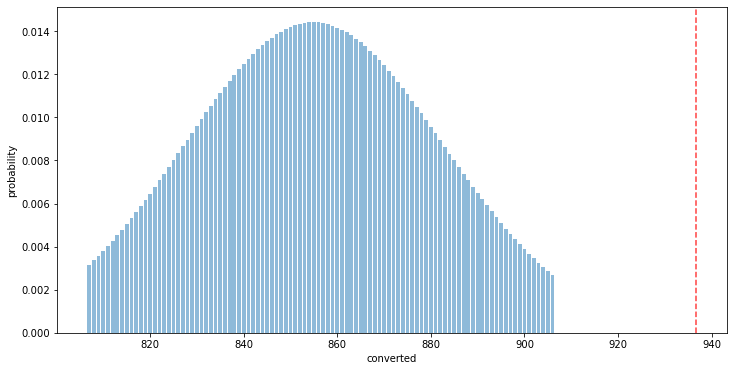

In [55]:
# plot using variable values
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_cr).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=B_cr * A_total, c='red', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

La distribución para el grupo de control se muestra en azul y el resultado del grupo de prueba se indica con la línea discontinua roja. Podemos ver que la probabilidad de obtener el resultado del grupo de prueba era muy baja. 

Sin embargo, la probabilidad no transmite el nivel de confianza de los resultados.

No tiene en cuenta el tamaño de la muestra de nuestro grupo de prueba.

Intuitivamente, nos sentiríamos más seguros de nuestros resultados a medida que el tamaño de la muestra fuera mayor. 

Continuemos y tracemos los resultados del grupo de prueba como una distribución binomial y comparemos las distribuciones entre sí.

### Binomial Distribution

Text(0, 0.5, 'probability')

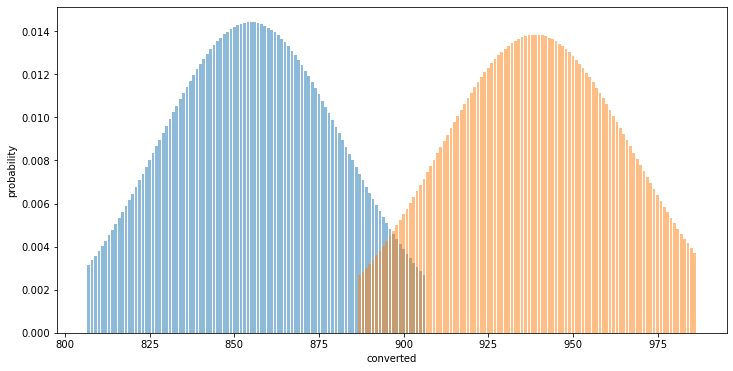

In [56]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, A_cr).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, B_cr).pmf(xB)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('converted')
plt.ylabel('probability')

Podemos ver que el grupo de prueba (naranja) convirtió más usuarios que el grupo de control (azul).

También podemos ver que el pico de los resultados del grupo de prueba es inferior al del grupo de control.

¿Cómo interpretamos la diferencia en la probabilidad de pico? 

Deberíamos centrarnos en la tasa de conversión para tener una comparación de manzanas con manzanas.

Para calcularlo, tenemos que estandarizar los datos y comparar la probabilidad de éxito, p, de cada grupo.

### Bernoulli Distribution and the Central Limit Theorem

Tomamos la media y la varianza según la distribución de Bernoulli (en la vida real sería la normal o cualquier otra).

Según el teorema del límite central, calculando muchas medias muestrales podemos aproximarnos a la verdadera media de la población,
 𝜇, de la que se tomaron los datos del grupo de control. 
 
La distribución de las medias muestrales, p, se distribuirá normalmente alrededor de la media real con una desviación estándar igual al 
error estándar de la media.

Lo mismo puede hacerse para el grupo de prueba. Así, tendremos dos distribuciones normales

Text(0, 0.5, 'PDF')

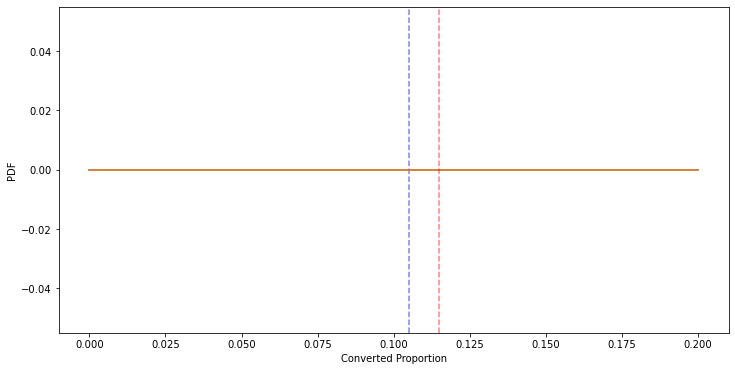

In [57]:
# standard error of the mean for both groups
SE_A = np.sqrt(A_cr * (1-A_cr)) / np.sqrt(A_total)
SE_B = np.sqrt(B_cr * (1-B_cr)) / np.sqrt(B_total)

# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))

xA = np.linspace(0, .2, 100)

yA = scs.norm(A_cr, SE_A).pdf(x)
ax.plot(xA, yA)
ax.axvline(x=A_cr, c='blue', alpha=0.5, linestyle='--')

xB = np.linspace(0, .2, 100)
yB = scs.norm(B_cr, SE_B).pdf(x)
ax.plot(xB, yB)
ax.axvline(x=B_cr, c='red', alpha=0.5, linestyle='--')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

Las líneas discontinuas representan el índice de conversión medio de cada grupo. La distancia entre la línea discontinua roja y la línea discontinua azul es igual a la diferencia media entre el grupo de control y el de prueba. d_hat es la distribución de la diferencia entre las variables aleatorias de los dos grupos.

Para comparar la hipótesis nula frente a la alternativa necesitaremos utilizar una ecuación para el error estándar agrupado.

In [58]:
def pooled_prob(N_A, N_B, X_A, X_B):
    """Devuelve la probabilidad conjunta de dos muestras"""
    return (X_A + X_B) / (N_A + N_B)

In [60]:
def pooled_SE(N_A, N_B, X_A, X_B):
    """Devuelve el error estándar agrupado para dos muestras"""
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

In [61]:
def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Devuelve el intervalo de confianza como una tupla"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

In [62]:
def z_val(sig_level=0.05, two_tailed=True):
    """Devuelve el valor z para un nivel de significación determinado"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z

In [63]:
def ab_dist(stderr, d_hat=0, group_type='control'):
    """Devuelve un objeto de distribución en función del tipo de grupo
    Ejemplos:
    Parámetros:
        stderr (float): error estándar agrupado de dos muestras independientes
        d_hat (float): la diferencia media entre dos muestras independientes
        tipo_de_grupo (cadena): Se admiten los tipos 'control' y 'test'.
    Devuelve:
        dist (objeto de distribución scipy.stats)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'test':
        sample_mean = d_hat

  # crea una distribución normal que depende de la media y la desviación estándar
    dist = scs.norm(sample_mean, stderr)
    return dist

In [65]:
def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """Devuelve el tamaño mínimo de la muestra para establecer una prueba de división
    Argumentos:
        bcr (float): probabilidad de éxito para el control, a veces
        se denomina tasa de conversión de referencia
        mde (float): cambio mínimo en la medición entre el grupo de control
        entre el grupo de control y el grupo de prueba si la hipótesis alternativa es verdadera
        se denomina a veces efecto mínimo detectable
        potencia (flotante): probabilidad de rechazar la hipótesis nula cuando la
        hipótesis nula es falsa, normalmente 0,8
        Nivel sig (flotante): nivel de significación, a menudo denominado alfa,
        normalmente 0,05
    Devuelve:
        min_N: tamaño mínimo de la muestra (float)
    Referencias:
        Conferencia de Stanford sobre el tamaño de las muestras
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
   # distribución normal estándar para determinar los valores z
    standard_norm = scs.norm(0, 1)

    # encontrar Z_beta de la potencia deseada
    Z_beta = standard_norm.ppf(power)

    # encontrar Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # media de las probabilidades de ambos grupos
    pooled_prob = (bcr + bcr+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N

In [66]:
def p_val(N_A, N_B, p_A, p_B):
    """Devuelve el valor p de una prueba A/B"""
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

Comparar la hipótesis nula con la hipótesis alternativa

La hipótesis nula es la posición de que el cambio en el diseño realizado para el grupo de prueba no produciría ningún cambio en la tasa de conversión. (Distribución en torno a 0, error agrupado)

La hipótesis alternativa es la posición contraria, según la cual el cambio de diseño realizado para el grupo de prueba daría lugar a una mejora (o reducción) del índice de conversión. (Distribución d_dat,Error agrupado)

In [67]:
def plot_norm_dist(ax, mu, std, with_CI=False, sig_level=0.05, label=None):
    """Añade una distribución normal a los ejes proporcionados
    Ejemplo:
        plot_norm_dist(ax, 0, 1) # traza una distribución normal estándar
    Parámetros:
        ax (ejes matplotlib)
        mu (float): media de la distribución normal
        std (float): desviación estándar de la distribución normal
    Devuelve:
        Ninguno: la función añade un gráfico al objeto ejes proporcionado
    """
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    y = scs.norm(mu, std).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, std, sig_level=sig_level)

In [68]:
def plot_binom_dist(ax, n, p, label=None):
    """Añade una distribución binomial a los ejes proporcionados
    Ejemplo:
        plot_binom_dist(ax, 0, 1) # traza una distribución normal estándar
    Parámetros:
        ax (ejes matplotlib)
        mu (float): media de la distribución normal
        sig (float): desviación estándar de la distribución normal
    Devuelve:
        Ninguno: la función añade un gráfico al objeto ejes proporcionado
    """
    x = np.linspace(0, n, n+1)
    y = scs.binom(n, p).pmf(x)
    ax.plot(x, y, label=label)

In [69]:
def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calcula el intervalo de confianza de dos colas y añade el gráfico a
    un objeto de ejes.
    Ejemplo:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parámetros:
        ax (matplotlib axes)
        mu (float): media
        s (float): desviación estándar
    Devuelve:
        Ninguno: la función añade un gráfico al objeto ejes proporcionado
    """
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)

In [70]:
def plot_null(ax, stderr):
    """Traza la distribución de la hipótesis nula en la que si no hay un cambio real
    la distribución de las diferencias entre los grupos de prueba y de control
    se distribuirá normalmente.
    También se traza la banda de confianza.
    Ejemplo:
        plot_null(ax, stderr)
    Parámetros:
        ax (ejes de matplotlib)
        stderr (float): el error estándar agrupado del grupo de control y de prueba
    Devuelve:
        None: la función añade un gráfico al objeto axes proporcionado
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)

In [71]:
def plot_alt(ax, stderr, d_hat):
    """Traza la distribución de la hipótesis alternativa en la que si hay un verdadero
    cambio, la distribución de las diferencias entre el grupo de prueba y el de
    grupos de control se distribuirá normalmente y se centrará en d_hat
    También se traza la banda de confianza.
    Ejemplo:
        plot_alt(ax, stderr, d_hat=0.025)
    Parámetros:
        ax (ejes de matplotlib)
        stderr (float): el error estándar agrupado del grupo de control y de prueba
    Devuelve:
        Ninguno: la función añade un gráfico al objeto axes proporcionado
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")

In [72]:
def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Ejemplo de gráfico de la prueba AB
    Ejemplo:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parámetros:
        n (int): tamaño total de la muestra para los grupos de control y de prueba (N_A + N_B)
        bcr (float): tasa de conversión base; tasa de conversión del control
        d_hat: diferencia en el índice de conversión entre los grupos de control y de prueba
            de prueba, a veces denominada **efecto mínimo detectable** al calcular el
            al calcular el tamaño mínimo de la muestra, o **elevación** cuando se habla de
            mejora positiva deseada al lanzar un cambio.
    Devuelve:
        Ninguno: la función traza una prueba AB como dos distribuciones para
        para su visualización.
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

In [73]:
def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x < right))
        ax.text(-3 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

In [74]:
def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas
    # for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()

In [75]:
def abplot_CI_bars(N, X, sig_level=0.05, dmin=None):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        N (list or tuple): sample size for all groups
        X (list or tuple): number of conversions for each variant
        sig_level (float): significance level
        dmin (float): minimum desired lift; a red and green dashed lines are
            shown on the plot if dmin is provided.
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # get control group values
    N_A = N[0]
    X_A = X[0]

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(1, len(N)):
        X_B = X[idx]
        N_B = N[idx]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)

    y = np.arange(len(N)-1)

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # plot veritcal dashed lines if dmin is provided
    if dmin is not None:
        ax.axvline(-dmin, c='red', linestyle='--', alpha=0.75)
        ax.axvline(dmin, c='green', linestyle='--', alpha=0.75)

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['variant{}'.format(idx+1) for idx in range(len(N)-1)]
    plt.yticks(np.arange(len(N)-1), labels)

In [76]:
def funnel_CI_plot(A, B, sig_level=0.05):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        A (list of tuples): (sample size, conversions) for control group funnel
        B (list of tuples): (sample size, conversions) for test group funnel
        sig_level (float): significance level
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(len(A)):
        X_A = A[idx][1]
        N_A = A[idx][0]
        X_B = B[idx][1]
        N_B = B[idx][0]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)
    print(d)

    y = np.arange(len(A))

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['metric{}'.format(idx+1) for idx in range(len(A))]
    plt.yticks(np.arange(len(A)), labels)

In [78]:
# A is control; B is test
N_A = 1000 # users allocated
N_B = 1000 # users allocated

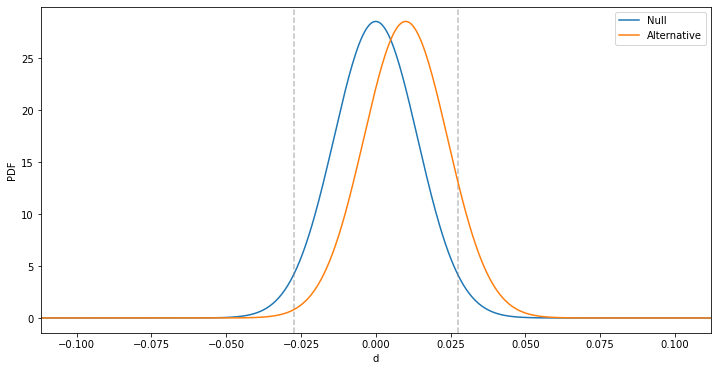

In [82]:
# define the parameters for abplot()
# use the actual values from the experiment for bcr and d_hat
# p_A is the conversion rate of the control group
# p_B is the conversion rate of the test group
n = N_A + N_B
bcr = A_cr
d_hat = B_cr - A_cr
abplot(N_A, N_B, bcr, d_hat)

In [83]:
import matplotlib.pyplot as plt

Visualmente, el gráfico de la hipótesis nula y alternativa es muy similar a los otros gráficos anteriores. 

Afortunadamente, ambas curvas tienen una forma idéntica, por lo que sólo podemos comparar la distancia entre las medias de las dos distribuciones. Podemos ver que la curva de la hipótesis alternativa sugiere que el grupo de prueba tiene una tasa de conversión más alta que el grupo de control. 

Este gráfico también puede utilizarse para determinar directamente la potencia estadística.

### 4. Statistical Power and Significance Level

Creo que es más fácil definir la potencia estadística y el nivel de significación mostrando primero cómo se representan en el gráfico de la hipótesis nula y alternativa. Podemos devolver una visualización de la potencia estadística añadiendo el parámetro show_power=True.

TypeError: alpha must be numeric or None, not a string

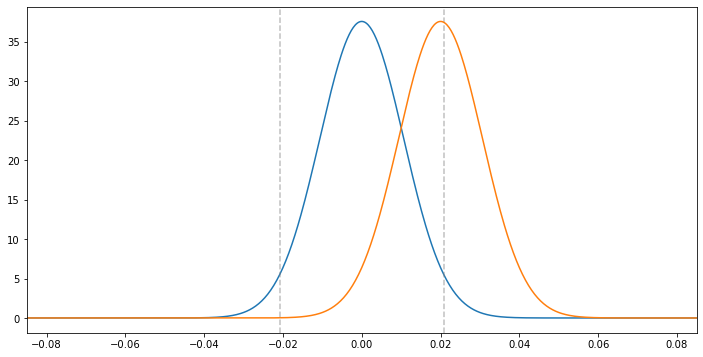

In [87]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

El área sombreada en verde representa la potencia estadística, y el valor calculado para la potencia también se muestra en el gráfico. 

Las líneas grises discontinuas en el gráfico anterior representan el intervalo de confianza (95% para el gráfico anterior) para la hipótesis nula. La potencia estadística se calcula encontrando el área bajo la distribución de la hipótesis alternativa y fuera del intervalo de confianza de la hipótesis nula.

Después de realizar nuestro experimento, obtenemos una tasa de conversión resultante para ambos grupos. Si calculamos la diferencia entre las tasas de conversión, obtenemos un resultado, la diferencia o el efecto del cambio de diseño. Nuestra tarea consiste en determinar de qué población procede este resultado, la hipótesis nula o la hipótesis alternativa.

El área bajo la curva de la hipótesis alternativa es igual a 1. 

Si el diseño alternativo es realmente mejor, la potencia es la probabilidad de que aceptemos la hipótesis alternativa y rechacemos la hipótesis nula y es igual al área sombreada en verde (verdadero positivo).
 El área opuesta bajo la curva alternativa es la probabilidad de que aceptemos la hipótesis nula y rechacemos la hipótesis alternativa (falso negativo). Esto se denomina beta en las pruebas A/B o pruebas de hipótesis y se muestra a continuación.

In [ ]:

abplot(N_A, N_B, bcr, d_hat, show_beta=True)